## Imports

In [1]:
import joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report,plot_confusion_matrix,plot_roc_curve,precision_score,roc_curve
import seaborn as sns
from sklearn.utils import shuffle
# from pandas_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

## Load data

In [3]:
df= pd.read_csv('dataset.csv')
df = shuffle(df,random_state=42)

sym_des = pd.read_csv('symptom_Description.csv')
sym_pre = pd.read_csv('symptom_precaution.csv')
df1 = pd.read_csv('Symptom-severity.csv')

In [14]:
df1

,Symptom,weight
0,itching,1
1,skin rash,3
2,nodal skin eruptions,4
3,continuous sneezing,4
4,shivering,5
...,...,...
128,inflammatory nails,2
129,blister,4
130,red sore around nose,2
131,yellow crust ooze,3


## Processing dataset

In [4]:
for col in df.columns:
    df[col] = df[col].str.replace('_',' ')

In [5]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4     348
Symptom_5    1206
Symptom_6    1986
Symptom_7    2652
Symptom_8    2976
Symptom_9    3228
Symptom_10   3408
Symptom_11   3726
Symptom_12   4176
Symptom_13   4416
Symptom_14   4614
Symptom_15   4680
Symptom_16   4728
Symptom_17   4848


In [6]:
df.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Acne,vomiting,vomiting,fatigue,high fever,headache,nausea,abdominal pain,abdominal pain,yellowing of eyes,yellowing of eyes,irritability,malaise,stomach bleeding,chest pain,chest pain,loss of smell,muscle pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


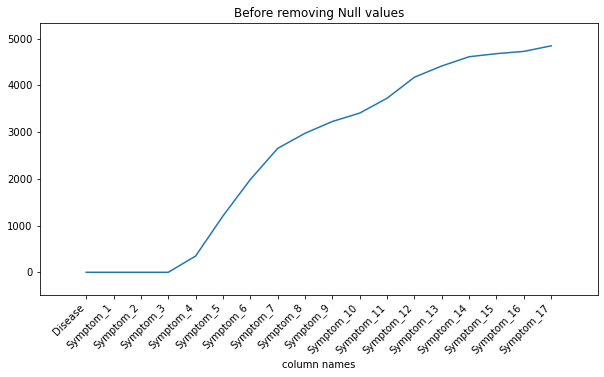

In [7]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('Before removing Null values')
plt.xlabel('column names')
plt.margins(0.1)
plt.show()

In [8]:
cols = df.columns
data = df[cols].values.flatten()

s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)

In [9]:
df = df.fillna(0)

#### Processing 2 severity

In [10]:
df1['Symptom'] = df1['Symptom'].str.replace('_',' ')

In [11]:
df1['Symptom'].unique()

array(['itching', 'skin rash', 'nodal skin eruptions',
       'continuous sneezing', 'shivering', 'chills', 'joint pain',
       'stomach pain', 'acidity', 'ulcers on tongue', 'muscle wasting',
       'vomiting', 'burning micturition', 'spotting urination', 'fatigue',
       'weight gain', 'anxiety', 'cold hands and feets', 'mood swings',
       'weight loss', 'restlessness', 'lethargy', 'patches in throat',
       'irregular sugar level', 'cough', 'high fever', 'sunken eyes',
       'breathlessness', 'sweating', 'dehydration', 'indigestion',
       'headache', 'yellowish skin', 'dark urine', 'nausea',
       'loss of appetite', 'pain behind the eyes', 'back pain',
       'constipation', 'abdominal pain', 'diarrhoea', 'mild fever',
       'yellow urine', 'yellowing of eyes', 'acute liver failure',
       'fluid overload', 'swelling of stomach', 'swelled lymph nodes',
       'malaise', 'blurred and distorted vision', 'phlegm',
       'throat irritation', 'redness of eyes', 'sinus pressu

In [12]:
vals = df.values
symptoms = df1['Symptom'].unique()

for i in range(len(symptoms)):
    vals[vals == symptoms[i]] = df1[df1['Symptom'] == symptoms[i]]['weight'].values[0]
    
d = pd.DataFrame(vals, columns=cols)

In [13]:
d

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Acne,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acne,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hyperthyroidism,4,3,3,5,3,6,5,4,2,2,6,0,0,0,0,0,0
3,AIDS,3,6,7,5,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chronic cholestasis,1,5,3,5,4,4,4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,Psoriasis,3,3,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0
4916,Peptic ulcer diseae,5,5,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0
4917,Dengue,3,3,3,5,4,7,3,5,4,4,3,6,2,3,0,0,0
4918,Fungal infection,1,3,4,dischromic patches,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
d = d.replace('dischromic  patches', 0)
d = d.replace('spotting  urination',0)
df = d.replace('foul smell of urine',0)

In [16]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4       0
Symptom_5       0
Symptom_6       0
Symptom_7       0
Symptom_8       0
Symptom_9       0
Symptom_10      0
Symptom_11      0
Symptom_12      0
Symptom_13      0
Symptom_14      0
Symptom_15      0
Symptom_16      0
Symptom_17      0


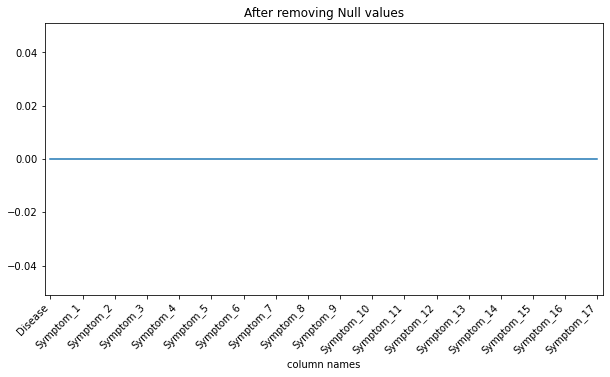

In [17]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('After removing Null values')
plt.xlabel('column names')
plt.margins(0.01)
plt.show()

In [18]:
print("Number of symptoms used to identify the disease ",len(df1['Symptom'].unique()))
print("Number of diseases that can be identified ",len(df['Disease'].unique()))

Number of symptoms used to identify the disease  132
Number of diseases that can be identified  41


### Decision tree


In [19]:
data = df.iloc[:,1:].values
labels = df['Disease'].values

In [21]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8,random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3936, 17) (984, 17) (3936,) (984,)


In [30]:
y_train[0]

'Urinary tract infection'

In [29]:
tree.predict([x_train[0]])

array(['Urinary tract infection'], dtype=object)

F1-score% = 95.7812664665753 | Accuracy% = 95.83333333333334


<AxesSubplot:>

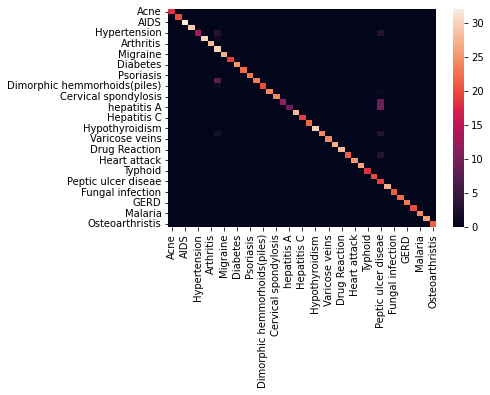

In [22]:
tree =DecisionTreeClassifier(criterion='gini',random_state=42,max_depth=13)
tree.fit(x_train, y_train)
preds=tree.predict(x_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)

In [15]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
DS_train =cross_val_score(tree, x_train, y_train, cv=kfold, scoring='accuracy')
pd.DataFrame(DS_train,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_train.mean()*100.0, DS_train.std()*100.0))

Mean Accuracy: 95.706%, Standard Deviation: (1.99%)


### Random forest

[3 5 3 5 4 4 3 2 3 0 0 0 0 0 0 0 0]
Migraine
F1-score% = 99.58380389536958 | Accuracy% = 99.59349593495935


<AxesSubplot:>

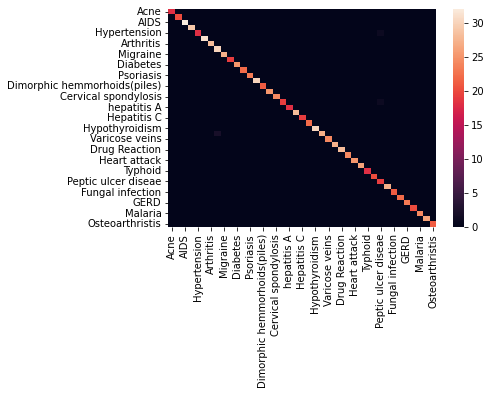

In [31]:
rnd_forest = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=13)
rnd_forest.fit(x_train,y_train)
preds=rnd_forest.predict(x_test)
print(x_test[0])
print(preds[0])
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)